## Loading Libraries

In [ ]:
#Main Libraries
import tensorflow as tf
import numpy as np
from collections import Counter

In [ ]:
#System and Files
from google.colab import drive, files
import kagglehub
import joblib

In [ ]:
#Keras modules
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model

In [ ]:
#Processing
import keras
from scipy.fftpack import dct
import cv2

In [ ]:
#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Model Aassessment
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
drive.mount('/content/gdrive') # mounting google drive

Mounted at /content/gdrive


## Data Loading

In [ ]:
!mkdir -p ~/.kaggle
files.upload()  # Uploading kaggle.json file
!mv kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [ ]:
api = KaggleApi()
api.authenticate()

In [ ]:
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print(f"Dataset downloaded to: {path}")

Using Colab cache for faster access to the 'cifake-real-and-ai-generated-synthetic-images' dataset.
Dataset downloaded to: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


In [ ]:
!dir /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3

dir: cannot access '/root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3': No such file or directory


In [ ]:
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


## Dataset Creation

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (32, 32)
DATA_DIR = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images"

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train",
    class_names = ['REAL', 'FAKE'], # so that 0 = "Real" and 1 = "Fake"
    validation_split = 0.15,
    subset = "training",
    seed = 123,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = True
)

Found 100000 files belonging to 2 classes.
Using 85000 files for training.


In [ ]:
print(train_ds.class_names)

['REAL', 'FAKE']


In [ ]:
def label_count(ds):
  """
  The function takes a tensor
  dataset as input and counts
  the number of class samples
  in it.

  params : tensorflow dataset
  returns : None
  """
  label_counter = Counter()

  for images, labels in ds:
      # Convert labels to numpy array
      labels_np = labels.numpy()

      label_counter.update(labels_np.tolist())

  for i, count in sorted(label_counter.items()):
      class_name = ds.class_names[i]
      print(f"Class '{class_name}' ({i}): {count} samples")

In [ ]:
label_count(train_ds)

Class 'REAL' (0): 42491 samples
Class 'FAKE' (1): 42509 samples


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train",
    class_names = ['REAL', 'FAKE'],
    validation_split = 0.15,
    subset = "validation",
    seed = 123,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = True
)

Found 100000 files belonging to 2 classes.
Using 15000 files for validation.


In [ ]:
label_count(val_ds)

Class 'REAL' (0): 7509 samples
Class 'FAKE' (1): 7491 samples


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory( # no need to set seed or shuffle since the whole directory content is read
    f"{DATA_DIR}/test",
    class_names = ['REAL', 'FAKE'],
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)

Found 20000 files belonging to 2 classes.


In [ ]:
label_count(test_ds)

Class 'REAL' (0): 10000 samples
Class 'FAKE' (1): 10000 samples


## Preprocessing

In [ ]:
def preprocessing(images, labels):
    """
    A function for preprocessing images.
    It converts the datatype of an image tensor
    into a float32 and rescales them between 0 and 1
    and resizes it.

    params: image : tf.float32
            label : int
    returns: tf.float32, int
    """
    images = tf.cast(images, tf.float32) / 255.0

    images = tf.image.resize(images, [32, 32])

    return images, labels

In [ ]:
def augment(images, labels):
    """
    A function for augmenting images.
    Firstly it calls the preprocessing function.
    After that, It flipps the image random along the
    x-axis. Then it applies random brightness
    and contrast change, and adds a small amount
    of gaussian noise. Finally, it clips the pixel
    values back to the range between 0 and 1.

    params: image : tf.float32
            label : tf.float32
    returns: tf.float32, tf.float32
    """
    images, labels = preprocessing(images, labels)
    images = tf.image.random_flip_left_right(images) #flipping images
    if tf.random.uniform(()) > 0.7:
        images = tf.image.random_brightness(images, max_delta=0.05) #changing brightess
    if tf.random.uniform(()) > 0.7:
        images = tf.image.random_contrast(images, lower=0.97, upper=1.03) #changing contrast
    if tf.random.uniform(()) > 0.7:
        noise = tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=0.02) #adding slight gaussian noise
        images = images + noise

    images = tf.clip_by_value(images, 0.0, 1.0) #clipping pixel values

    return images, labels

In [ ]:
def rgb_to_ycbcr_tf(images):
    """
    The function to turn RGB images
    to YCbCr representation. The
    conversion formula is based on
    JPEG File Interchange Format
    Version 1.02.

    params: image : tf.float32
    returns: tf.float32
    """

    r, g, b = images[..., 0], images[..., 1], images[..., 2]
    y  =  0.299 * r + 0.587 * g + 0.114 * b
    cb = -0.168736 * r - 0.331264 * g + 0.5 * b + 0.5 # 0.5 coefficent ensures that the values remain between [0, 1]
    cr =  0.5 * r - 0.418688 * g - 0.081312 * b + 0.5

    return tf.stack([y, cb, cr], axis = -1)

In [ ]:
def get_dct_batch_reduced(images, labels, k=20):
    """
    The fucntion takes, a batch of images as input,
    applies DCT to each channel, first along one axis
    on the spatial representation, then along the other
    axis to the output of the previous operation. Then
    a low-frequency filter is applied to the resulting
    matrix, retaining only the top-left k x k block of
    DCT coefficients. The the transformed channels are
    concatenated back into a 3D matrix. The function retruns the resulting
    3 x k x k matrix and the image label.

    params: image : tf.float32
            label : tf.float32
            k : int
    returns: tf.float32, int
    """
    ycbcr_images = rgb_to_ycbcr_tf(images)
    dct_channels = []

    for i in range(3):
        channel = ycbcr_images[..., i]

        #Apply 2D DCT per image in batch
        dct_1 = tf.signal.dct(channel, norm = 'ortho')
        dct_2 = tf.signal.dct(tf.transpose(dct_1, perm = [0, 2, 1]), norm = 'ortho')
        dct_final = tf.transpose(dct_2, perm = [0, 2, 1])  # Restore shape

        #Take the top-left k x k block (low-frequency)
        dct_cropped = dct_final[:, :k, :k]

        dct_channels.append(tf.expand_dims(dct_cropped, axis = -1))

    #Concatenate reduced channels
    dct_representation = tf.concat(dct_channels, axis = -1)

    return dct_representation, labels

In [ ]:
#Augmenting training and preprocessing validation and testing datasets
train_ds_augmented = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_augmented = val_ds.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_augmented = test_ds.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
#Transforming all three sets
train_ds_preprocessed = train_ds_augmented.map(get_dct_batch_reduced, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds_preprocessed = val_ds_augmented.map(get_dct_batch_reduced, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_augmented.map(get_dct_batch_reduced, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Checking the dimentions
for images, labels in train_ds_preprocessed.take(1):
    print(f"Image shape: {images.shape}")
    print(f"Label shape: {labels.shape}")

Image shape: (32, 20, 20, 3)
Label shape: (32,)


In [ ]:
for images, labels in val_ds_preprocessed.take(1):
    print(f"Image shape: {images.shape}")
    print(f"Label shape: {labels.shape}")

Image shape: (32, 20, 20, 3)
Label shape: (32,)


In [ ]:
for images, labels in test_ds_preprocessed.take(1):
    print(f"Image shape: {images.shape}")
    print(f"Label shape: {labels.shape}")

Image shape: (32, 20, 20, 3)
Label shape: (32,)


## Model

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Input(shape = (20, 20, 3)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, 3, padding = "same"))
model.add(layers.LeakyReLU(negative_slope = 0.1))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(128, 3, padding = "same"))
model.add(layers.LeakyReLU(0.1))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(256, 3, padding = "same"))
model.add(layers.LeakyReLU(0.1))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256))
model.add(layers.LeakyReLU(negative_slope = 0.1))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 20, 20, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 20, 20, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 436,877 (1.67 MB)

 Trainable params: 436,871 (1.67 MB)

 Non-trainable params: 6 (24.00 B)

In [ ]:
early_stopping = EarlyStopping( # implementing early stopping mechanism
    monitor = "val_loss",
    patience = 10,
    restore_best_weights = True)

In [ ]:
!mkdir -p /content/gdrive/MyDrive/models/checkpoints_classifier

In [ ]:
checkpoint_path = "/content/gdrive/MyDrive/models/checkpoints_classifier/model_epoch_{epoch:02d}.weights.h5"  # Save to Drive
checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_weights_only = True,
    save_freq = "epoch",
)

In [ ]:
model.compile(loss = "binary_crossentropy",
              metrics = ["accuracy"],
              optimizer = "adam")

## Training

In [ ]:
history = model.fit(train_ds_preprocessed,
                    epochs = 50,
                    batch_size = BATCH_SIZE,
                    validation_data = val_ds_preprocessed,
                    callbacks = [early_stopping,
                                 checkpoint_path
                                 ]
                    )

Epoch 1/50
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 200s 73ms/step - accuracy: 0.7710 - loss: 0.4604 - val_accuracy: 0.8769 - val_loss: 0.2880
Epoch 2/50
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 51s 19ms/step - accuracy: 0.8748 - loss: 0.2892 - val_accuracy: 0.8951 - val_loss: 0.2509
Epoch 3/50
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 48s 18ms/step - accuracy: 0.8924 - loss: 0.2583 - val_accuracy: 0.8926 - val_loss: 0.2575
Epoch 4/50
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 48s 18ms/step - accuracy: 0.9029 - loss: 0.2360 - val_accuracy: 0.9108 - val_loss: 0.2184
Epoch 5/50
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - accuracy: 0.9142 - loss: 0.2111 - val_accuracy: 0.9199 - val_loss: 0.2004
Epoch 6/50
 664/2657 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.9240 - loss: 0.1894

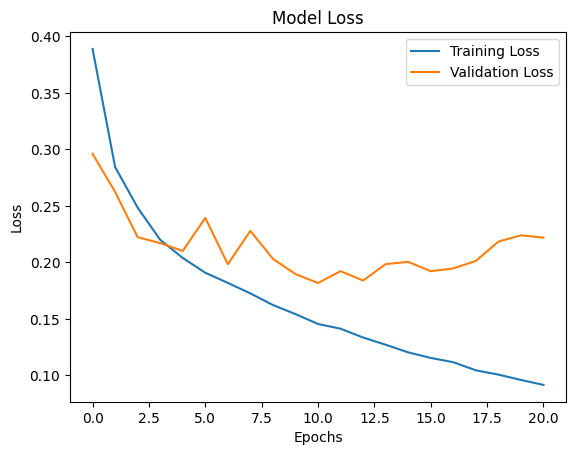

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

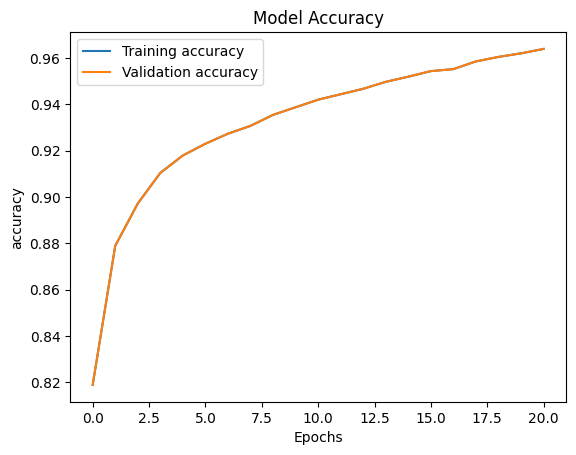

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["accuracy"]
plt.plot(acc, label = "Training accuracy")
plt.plot(val_acc, label = "Validation accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## Testing

In [ ]:
y_pred_probs = model.predict(test_ds_preprocessed)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten() #0.5 is the default threshold for sigmoid

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [ ]:
# Get labels from test dataset
y_true = np.concatenate([y.numpy() for _, y in test_ds_preprocessed])

### 32x32

In [ ]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     10000
           1       0.95      0.96      0.96     10000

    accuracy                           0.95     20000
   macro avg       0.96      0.95      0.95     20000
weighted avg       0.96      0.95      0.95     20000



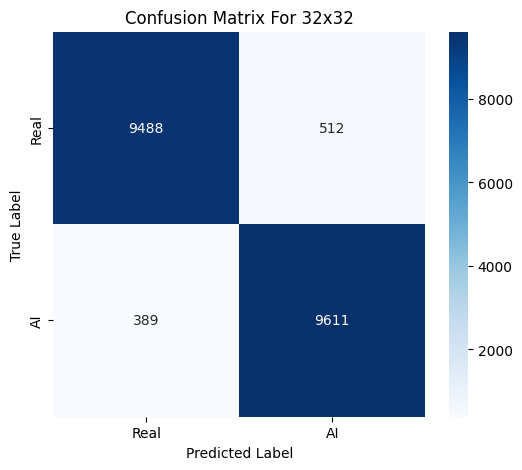

In [ ]:
labels = ["Real", "AI"]
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = labels, yticklabels = labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix For 32x32")
plt.show()

In [ ]:
model.save("/content/gdrive/MyDrive/project_model/model_classifier_32x32.keras") #saving the model

### 28 x 28

In [ ]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10000
           1       0.95      0.95      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000



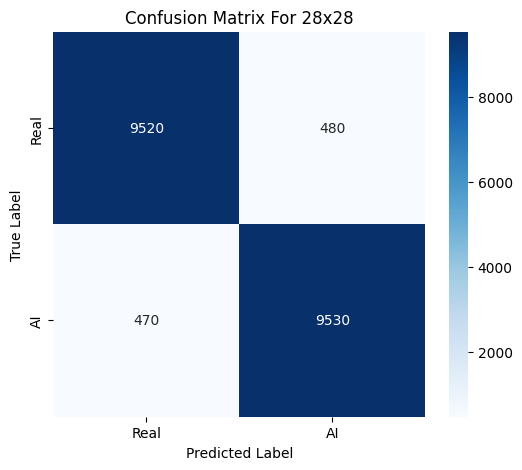

In [ ]:
labels = ["Real", "AI"]
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = labels, yticklabels = labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix For 28x28")
plt.show()

In [ ]:
model.save("/content/gdrive/MyDrive/project_model/model_classifier_28x28.keras")

### 24x24

In [ ]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10000
           1       0.94      0.94      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



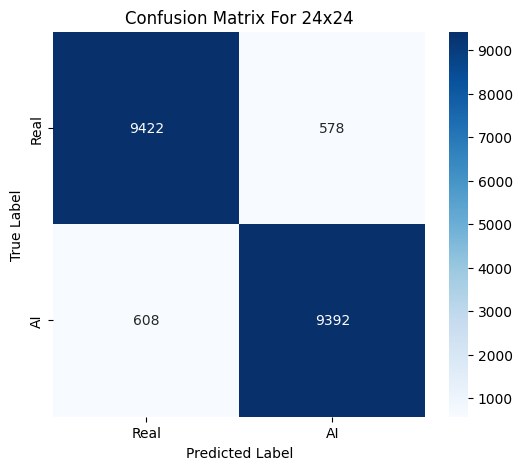

In [ ]:
labels = ["Real", "AI"]
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = labels, yticklabels = labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix For 24x24")
plt.show()

In [ ]:
model.save("/content/gdrive/MyDrive/project_model/model_classifier_24x24.keras")

### 20x20

In [ ]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93     10000
           1       0.94      0.93      0.93     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



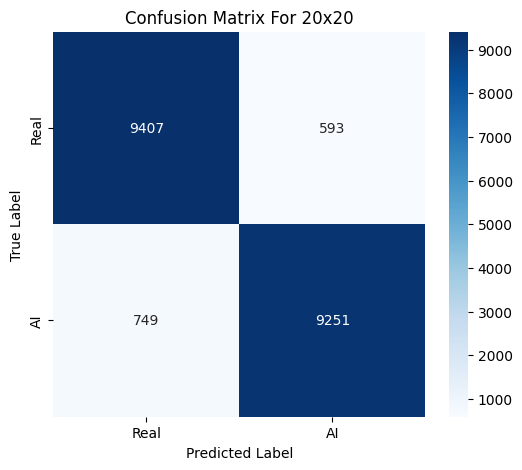

In [ ]:
labels = ["Real", "AI"]
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot = True, fmt= 'd', cmap = 'Blues',
            xticklabels = labels, yticklabels = labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix For 20x20")
plt.show()

In [ ]:
model.save("/content/gdrive/MyDrive/project_model/model_classifier_20x20.keras")

## 16 x 16

In [ ]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     10000
           1       0.92      0.92      0.92     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



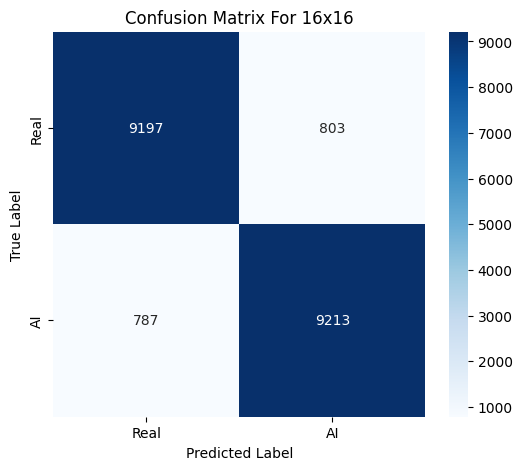

In [ ]:
labels = ["Real", "AI"]
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = labels, yticklabels = labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix For 16x16")
plt.show()

In [ ]:
model.save("/content/gdrive/MyDrive/project_model/model_classifier_16x16.keras")

## Conclusion

The accuracy does not fall if the filtering is performed, and the dimensions are reduced by 23%, to 28 x 28. The performance falls only slightly in the cases of 24 x 24 and 20 x 20 matrices, by 1% and 2% respectively. Finally, the model demonstrates 92% accuracy with a 75% reduction in size, to 16 x 16.

These findings can allow for a more efficient storage of training dataset and faster training process of AI-detection systems by using more compact datasets.